##한글 국문으로 데이터 분석 

In [1]:
# 한글 분석 라이브러리 설치.
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.6 MB/s 
     |████████████████████████████████| 448 kB 46.4 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
# 한글 (나눔) 글꼴 설치 (시각화를 위해서).
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplitlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,352 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

In [9]:
from wordcloud import WordCloud  #wordcloud 
import konlpy #한글 분석 라이브러리 
import numpy as np 
import pandas as pd 
import re 
import matplotlib.pyplot as plt
from PIL import Image  #pillow 패키지 에서 이미지 관련 라이브러리

In [10]:
plt.rc('font',family = 'NanumBarunGothic')


In [12]:
f = open("/content/drive/MyDrive/인공지능사관학교/빅데이터/03_확률 모델링_업데이트/data/example_seoul_government.txt",'r',encoding = "ms949") #encoding 필수 
my_text = f.readlines()
f.close

<function TextIOWrapper.close>

In [13]:
my_text[:10]

['305 무료법률상담에 대한 부탁의 말씀 입니다. 2014-09-27 2 \n',
 '304 [교통불편접수] 6715 버스(신월동->상암동) 2014-09-26 2 \n',
 '303 경기도 시흥시 아파트 화재~ 2014-09-22 145 \n',
 '302 마곡지구 하자보수 관련 2014-09-22 57 \n',
 '301 가깝고도 먼 강남(성수동에서 압구정역 방면) 2014-09-22 83 \n',
 '300 청담나들목(제외지측)입구 주변지역안내도 정비 필요 2014-09-22 20 \n',
 '299 전 제주도 시민입니다만.. 2014-09-16 2 \n',
 '298 지방자치제 실시로 소요되는 비용 2014-09-16 0 \n',
 '297 평생 살던 삶의 터전인 주택을 빼앗기게 생겼습니다ㅠ 2014-09-15 5 \n',
 '296 불법확장노점상 이전 및 원상복구 시장님께 강력 요청 2014-09-15 1 \n']

##전처리 

In [14]:
no_meaning = "관련|요청|개선|건의|시장|민원|이용"
no_meaning += "|관리|문제|불편|설치|불법|제안|필요"
no_meaning += "|정책|언제|대책|서울시|서울|박원순|요망|부탁|주세요|의|대한" #| (or 기호를 통해서 의미 없는 단어를 정리 )
my_text_clean = []

for a_line in my_text:
  a_line = re.sub("\\+",' ',a_line) #특수 문자 스페이스로 대처
  a_line = re.sub("\d+",' ',a_line) #수치 데이터 스페이스로 대처
  a_line = re.sub("[-!?()>~.,]",' ',a_line) #특수문자 스페이스 대처
  a_line = re.sub("\n",' ',a_line) #줄바꿈 스페이스로 대처 
  a_line = re.sub("[\[\]]",' ',a_line) #대괄호를 스페이스로 대처 
  a_line = re.sub("[a-zA-Z]",' ',a_line) #영문자 스페이스로 대처 -> 한글 데이터 만 필요하니까 
  a_line = re.sub("ㅠ|ㅋ|ㅎ",' ',a_line) # ㅠ|ㅋ|ㅎ 문자를 대처 | -> or 기호 
  a_line = re.sub(no_meaning,' ',a_line) #의미 없는 단어 스페이스 로 대처 
  a_line = re.sub("\s+",' ',a_line) #잉여 스페이스 를 줄임
  my_text_clean.append(a_line)
  

In [15]:
my_text_clean[:10]

[' 무료법률상담에 말씀 입니다 ',
 ' 교통 접수 버스 신월동 상암동 ',
 ' 경기도 시흥시 아파트 화재 ',
 ' 마곡지구 하자보수 ',
 ' 가깝고도 먼 강남 성수동에서 압구정역 방면 ',
 ' 청담나들목 제외지측 입구 주변지역안내도 정비 ',
 ' 전 제주도 시민입니다만 ',
 ' 지방자치제 실시로 소요되는 비용 ',
 ' 평생 살던 삶 터전인 주택을 빼앗기게 생겼습니다 ',
 ' 확장노점상 이전 및 원상복구 님께 강력 ']

###한글 단어 추출

In [18]:
#twi 한글 
my_tagger = konlpy.tag.Okt()

In [20]:
my_words = []
for a_line in my_text_clean:
  my_words.extend(my_tagger.nouns(a_line)) #a_line 에서 명사만 추출  = nonus 


In [21]:
#단음절 = 한글자 제거 
my_words_2 = []
for a_word in my_words:
  if len(a_word) >1:
    my_words_2+=[a_word]

In [23]:
my_words_2[:30]

['무료',
 '법률',
 '상담',
 '말씀',
 '교통',
 '접수',
 '버스',
 '신월동',
 '상암동',
 '경기도',
 '시흥시',
 '아파트',
 '화재',
 '마곡지구',
 '하자',
 '보수',
 '강남',
 '성수동',
 '압구정역',
 '방면',
 '청담',
 '나들목',
 '외지',
 '입구',
 '주변',
 '지역',
 '안내',
 '정비',
 '제주도',
 '시민']

##키워드 추출

In [24]:
my_series = pd.Series(my_words_2)

In [25]:
my_word_counts = my_series.value_counts().sort_values(ascending = False)

In [26]:
#딕셔너리 방식으로 wordcount 만들기 
my_dict = {}
for an_index ,a_value in zip(my_word_counts.index,my_word_counts.values):
  my_dict[an_index] = a_value

In [27]:
wc = WordCloud(font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic',background_color='white',max_words = 30)
wc.generate_from_frequencies(my_dict)

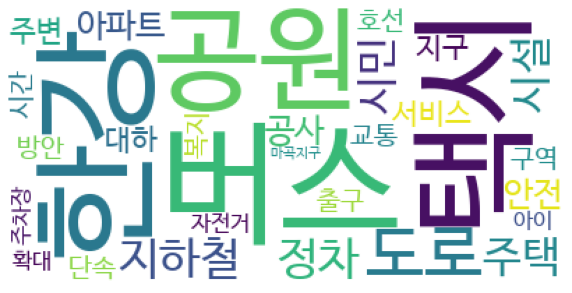

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis("off")                                    # 축을 꺼줌.
plt.show()


##word cloud mask 착용

In [38]:
# 다음은 워드클라우드의 요구사항.
a_long_sentence = ' '.join(my_words_2)
a_long_sentence

'무료 법률 상담 말씀 교통 접수 버스 신월동 상암동 경기도 시흥시 아파트 화재 마곡지구 하자 보수 강남 성수동 압구정역 방면 청담 나들목 외지 입구 주변 지역 안내 정비 제주도 시민 지방자치제 실시 소요 비용 평생 터전 주택 확장 노점상 이전 원상 복구 강력 다자 장기 전세 자동차 가액 규제 완화 이첨 소공동 롯데 면세점 횡포 보도 정차 예방 방안 뉴타운 재개발 정비 조합 부조리 조사 버스 롯데 개장 버스정류장 이동 폐쇄 화단 체육 시설 장님 마포 한국 산업 인력 공단 부지 교육 시설 건립 한강 보행 호안 사면 안전 대하 어른 안전 불감증 아이 고통 사회 약자 상인 건물 일방 횡포 구청 보아 택시 타고 가기 항공기 소음 마곡지구 소셜 믹스 독립운동가 김상옥 후손 사연 신림동 도림천 발견 싱크홀 상향 외면 상태 약속 어린이집 행태 내곡동 상향 강변북로 올림픽대로 졸음 휴게소 행정심판 적법 공익 조사 공사 장기전 진행 정차 조치 호소 송파구 석촌동 싱크홀 발생 원인 대해 집주인 내용증명 수취 거절 봉제 산업 차별 택시 사기 월드컵경기 한강 공원 지구 외국인 관광객 장애우 휠체 대여 어린이 보호 구역 전체 금연 구역 지정 신규 최상 위도 메인 지하철 막차 환승 시간 조정 중랑천 화장실 시립 노인 복지 시설 공사 교통 소통 월드컵대교 공사 마포 단속 상암동 상공 훈련 항공기 고도 비행 공동 주택 사용승인 조건 사지 입장 보시 출구 좌판 단속 안보 현장 체험 학습 공동 주택 사용 검사 내용 추가 질문 버스 정차 광역 버스 운행 한강 주변 시민 공간 초등학교 등하교 시간 건설 차량 통행 제한 용산 도서관 이전 박람회 택시 전액 대하 버스 고양 삼송 동산 마을 단지 정차 카지노 쓰레기 다른 서민 국민 주택 기금 대출 주정 차단 제대로 좀햊세 학교 관공서 실시간 미세먼지 측정기 지하철 서점 내일 배움 카드 성공 취업 패키지 모기 때문 생활 외국인 관광 차량 정차 대하 장애인 주차장 염강 나들목 전광판 고장 자연 생각 단체 명동 고성 전도 활동 대해 한강 보행 토사 제거 청

In [35]:
img  = Image.open('/content/drive/MyDrive/인공지능사관학교/빅데이터/03_확률 모델링_업데이트/data/background_3.png')
back_mask = np.array(img)

In [39]:
wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic',background_color='white',max_words = 50,mask = back_mask)
wc.generate(a_long_sentence)

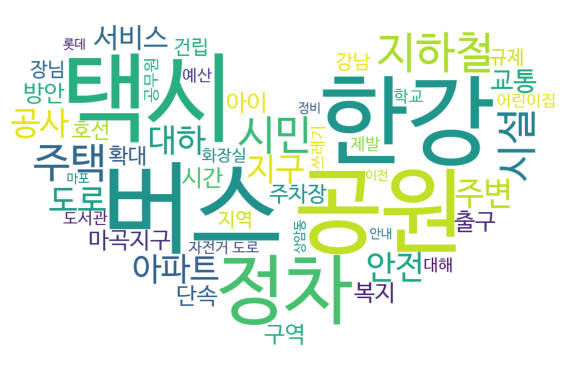

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.show()